In [16]:
import numpy as np
import os.path as osp
import os
import subprocess
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline


In [17]:
#sess = tf.Session()

In [18]:
def loading_mnist():
    data_url = 'http://yann.lecun.com/exdb/mnist/'
    download_dir = osp.join('mnist_data','mnist')
    if osp.exists(download_dir):
        print('minist is found, no need to download')
        return
    else:
        os.mkdir(download_dir)
        
    keys = ['train-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz',
            'train-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
    for k in keys:
        url = (data_url+k).format(**locals())
        target_path = osp.join(download_dir, k)
        cmd = ['curl', url, '-o', target_path]
        print('Downloading ', k)
        subprocess.call(cmd)
        cmd = ['gzip', '-d', target_path]
        print('Unzip ', k)
        subprocess.call(cmd)  

In [19]:
loading_mnist()

minist is found, no need to download


In [20]:
def read_mnist():
    num_train = 60000
    num_test = 10000    
    def read(filename,num,shape):
        fd = open(osp.join('mnist_data\\mnist', filename))
        loaded = np.fromfile(file=fd, dtype=np.uint8)
        return loaded[num:].reshape(shape).astype(np.float)
    
    train_image = read('train-images-idx3-ubyte', 16, (num_train, 28, 28, 1))
    train_label = read('train-labels-idx1-ubyte', 8, num_train)
    test_image = read('t10k-images-idx3-ubyte', 16, (num_test, 28, 28, 1))
    test_label = read('t10k-labels-idx1-ubyte', 8, num_test)
    return train_image, train_label, test_image, test_label

In [21]:
X_train, Y_train, X_test, Y_test = read_mnist()
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))


60000
60000
10000
10000


In [22]:
def conv2d_from_contrib(input, filter_size, num_stride, num_filter):
    return tf.contrib.layers.conv2d(input, num_outputs=num_filter, kernel_size=filter_size, stride=num_stride,
                                   activation_fn = tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer())

def fully_connected(input, output_dim, weight_init = tf.random_normal_initializer(0.0, 0.02)):
    return tf.contrib.layers.fully_connected(input, output_dim, activation_fn=None, weights_initializer=weight_init)

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def dropout(input,rate_p):
    return tf.layers.dropout(input, rate=rate_p)


In [23]:
class Le_Net5(object):
    def __init__(self):
        self.num_epoch = 10
        self.batch_size = 64
        self.log_step = 50
        self.highest_accuracy=0.
        self._build_model()
    
    def _model(self):
        print('---Le_Net5---')
        
        print('intput: ' + str(self.X.get_shape()))
        
        with tf.variable_scope('conv1'):
            self.conv1 = conv2d_from_contrib(self.X,5,1,6)
            #print('conv1: ' + str(self.conv1.get_shape()))
        
        with tf.variable_scope('max_pooling1'):
            self.maxpool1 = max_pool(self.conv1, 2, 2)
            #print('maxpool1: ' + str(self.maxpool1.get_shape()))
            
        with tf.variable_scope('conv2'):
            self.conv2 = conv2d_from_contrib(self.maxpool1,5,1,16)
            #print('conv2: ' + str(self.conv2.get_shape()))
        
        with tf.variable_scope('max_pooling2'):
            self.maxpool2 = max_pool(self.conv2, 2, 2)
            #print('maxpool2: ' + str(self.maxpool2.get_shape()))
        
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d_from_contrib(self.maxpool2,5,1,120)
            #print('conv3: ' + str(self.conv3.get_shape()))
        
        self.flat = tf.contrib.layers.flatten(self.conv3)
        
        with tf.variable_scope('fc1'):
            self.fc1 = fully_connected(self.flat, 84, weight_init = tf.random_normal_initializer(0.0, 0.1))
            #print('fc1 ' + str(self.fc1.get_shape()))
        
        with tf.variable_scope('fc2'):
            self.fc2 = fully_connected(self.fc1, 10, weight_init = tf.random_normal_initializer(0.0, 0.1))
            #print('fc2 ' + str(self.fc2.get_shape()))
        
        return self.fc2
    
    def _input_ops(self):
        self.X = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.Y = tf.placeholder(tf.int64, [None])
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        
    def _build_optimizer(self):
        step = tf.Variable(0)
        self.lr = tf.train.exponential_decay(1e-4,step,500,0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss_op, global_step = step)
        
    def _loss(self,labels,logits):
        self.loss_op = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits)) 
    
    def _build_model(self):
        self._input_ops()
        labels = tf.one_hot(self.Y, 10)
        logits = self._model()
        self._loss(labels, logits)
        self._build_optimizer()
        
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())
        step = 0
        losses = []
        accuracies = []
        train_acc = []
        test_acc = []
        
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]              
                feed_dict = {self.X: X_, self.Y:Y_}              
                fetches = [self.train_op, self.loss_op, self.accuracy_op]
                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1
#             # Graph 1. X: epoch, Y: training loss
#             x1 = np.linspace(0, epoch + 1, len(losses))
#             plt.plot(x1, np.array(losses), label='epoch-loss')
#             plt.xlabel('epoch')
#             plt.ylabel('training loss')
#             plt.legend()
#             plt.grid(True)
#             plt.show()
#             # Graph 2. X: epoch, Y: training accuracy
#             x2 = np.linspace(0, epoch + 1, len(losses))
#             plt.plot(x2, np.array(accuracies), label='epoch-accuracy_train')
#             plt.xlabel('epoch')
#             plt.ylabel('accuracy')
#             plt.legend()
#             plt.grid(True)
#             plt.show()
            # Print validation results
            print('validation for epoch %d' % epoch)
            train_accuracy = self.evaluate(sess, X_train, Y_train)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            if val_accuracy>self.highest_accuracy:
                self.highest_accuracy=val_accuracy
            train_acc.append(train_accuracy)
            test_acc.append(val_accuracy)           
            print('-  epoch %d: Train accuracy = %.3f' % (epoch, train_accuracy))
            print('-  epoch %d: Test accuracy = %.3f' % (epoch, val_accuracy))
        # Graph 3. X: epoch, Y: Train_accuray
        x1 = np.linspace(0, epoch + 1, len(train_acc))
        plt.plot(x1, np.array(train_acc), label='epoch-train_accuracy')
        plt.xlabel('epoch')
        plt.ylabel('training accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
        # Graph 4. X: epoch, Y: Test_accuray
        x1 = np.linspace(0, epoch + 1, len(test_acc))
        plt.plot(x1, np.array(test_acc), label='epoch-test_accuracy')
        plt.xlabel('epoch')
        plt.ylabel('testing accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
        print("Highest test accuracy is: " + str(self.highest_accuracy))
            
            
            
            
                
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            feed_dict = {self.X:X_, self.Y:Y_}
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter  


In [24]:
num_training = 60000
num_test = 10000

In [25]:
tf.reset_default_graph()

---Le_Net5---
intput: (?, 28, 28, 1)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 5384.911, accuracy = 0.062
iteration (50): loss = 229.132, accuracy = 0.766
iteration (100): loss = 115.726, accuracy = 0.891
iteration (150): loss = 201.952, accuracy = 0.797
iteration (200): loss = 160.707, accuracy = 0.828
iteration (250): loss = 211.062, accuracy = 0.766
iteration (300): loss = 43.853, accuracy = 0.938
iteration (350): loss = 33.674, accuracy = 0.953
iteration (400): loss = 39.967, accuracy = 0.953
iteration (450): loss = 67.472, accuracy = 0.906
iteration (500): loss = 74.466, accuracy = 0.875
iteration (550): loss = 85.065, accuracy = 0.844
iteration (600): loss = 34.302, accuracy = 0.938
iteration (650): loss = 99.410, accuracy = 0.906
iteration (700): loss = 63.873, accuracy = 0.922
iteration (750): loss = 44.619, accuracy = 0.938
iteration (800): loss = 130.743, accuracy = 0.875
iteration (850): loss = 31.329, accuracy = 0.953
iteration (900): loss = 63.27

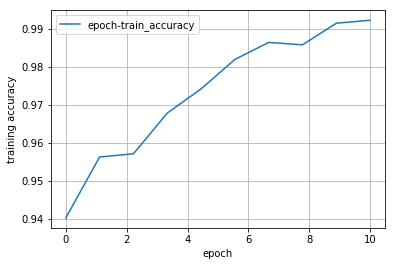

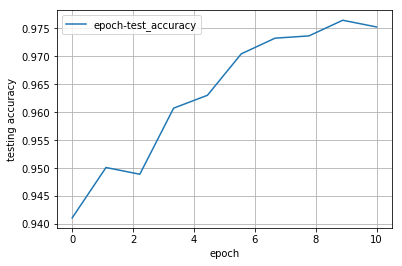

Highest test accuracy is: 0.976462339744
***** Last accuracy: 0.975


In [26]:
with tf.Session() as sess:
    model = Le_Net5()
    model.train(sess, X_train, Y_train, X_test, Y_test)
    accuracy = model.evaluate(sess, X_test, Y_test)
    print('***** Last accuracy: %.3f' % accuracy)
        

In [14]:
class Super_Le_Net5(object):
    def __init__(self):
        self.num_epoch = 50
        self.batch_size = 128
        self.log_step = 50
        self.highest_accuracy=0.
        self._build_model()
        
              
    def _model(self):
        print('---Super Le_Net5---')
        
        print('intput: ' + str(self.X.get_shape()))
        
        with tf.variable_scope('conv1'):
            self.conv1 = conv2d_from_contrib(self.X,4,2,64)
            print('conv1: ' + str(self.conv1.get_shape()))
        with tf.variable_scope('conv2'):
            self.conv2 = conv2d_from_contrib(self.conv1,4,2,128)
            print('conv2: ' + str(self.conv2.get_shape()))
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d_from_contrib(self.conv2,4,2,384)
            print('conv3: ' + str(self.conv3.get_shape()))
            
        self.flat = tf.contrib.layers.flatten(self.conv3)
            
        with tf.variable_scope('fc1'):
            self.fc1 = fully_connected(self.flat, 384, weight_init = tf.contrib.layers.xavier_initializer())
            print('fc1 ' + str(self.fc1.get_shape()))
            
        with tf.variable_scope('fc2'):
            self.fc2 = fully_connected(self.fc1, 192, weight_init = tf.contrib.layers.xavier_initializer())
            print('fc2 ' + str(self.fc2.get_shape())) 
        
        with tf.variable_scope('fc3'):
            self.fc3 = fully_connected(self.fc2, 10, weight_init = tf.contrib.layers.xavier_initializer())
            print('fc3 ' + str(self.fc3.get_shape()))    
                      
        return self.fc3
    
    def _input_ops(self):
        self.X = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.Y = tf.placeholder(tf.int64, [None])
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        
    def _build_optimizer(self):
        step = tf.Variable(0)
        self.lr = tf.train.exponential_decay(1e-4,step,500,0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss_op, global_step = step)
        
    def _loss(self,labels,logits):
        self.loss_op = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits)) 
    
    def _build_model(self):
        self._input_ops()
        labels = tf.one_hot(self.Y, 10)
        logits = self._model()
        self._loss(labels, logits)
        self._build_optimizer()
        
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())
        step = 0
        losses = []
        accuracies = []
        train_acc = []
        test_acc = []
        
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]              
                feed_dict = {self.X: X_, self.Y:Y_}              
                fetches = [self.train_op, self.loss_op, self.accuracy_op]
                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1
#             # Graph 1. X: epoch, Y: training loss
#             x1 = np.linspace(0, epoch + 1, len(losses))
#             plt.plot(x1, np.array(losses), label='epoch-loss')
#             plt.xlabel('epoch')
#             plt.ylabel('training loss')
#             plt.legend()
#             plt.grid(True)
#             plt.show()
#             # Graph 2. X: epoch, Y: training accuracy
#             x2 = np.linspace(0, epoch + 1, len(losses))
#             plt.plot(x2, np.array(accuracies), label='epoch-accuracy_train')
#             plt.xlabel('epoch')
#             plt.ylabel('accuracy')
#             plt.legend()
#             plt.grid(True)
#             plt.show()
            # Print validation results
            print('validation for epoch %d' % epoch)
            train_accuracy = self.evaluate(sess, X_train, Y_train)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            if val_accuracy>self.highest_accuracy:
                self.highest_accuracy = val_accuracy
            train_acc.append(train_accuracy)
            test_acc.append(val_accuracy)           
            print('-  epoch %d: Train accuracy = %.3f' % (epoch, train_accuracy))
            print('-  epoch %d: Test accuracy = %.3f' % (epoch, val_accuracy))
        # Graph 3. X: epoch, Y: Train_accuray
        x1 = np.linspace(0, epoch + 1, len(train_acc))
        plt.plot(x1, np.array(train_acc), label='epoch-train_accuracy')
        plt.xlabel('epoch')
        plt.ylabel('training accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
        # Graph 4. X: epoch, Y: Test_accuray
        x1 = np.linspace(0, epoch + 1, len(test_acc))
        plt.plot(x1, np.array(test_acc), label='epoch-test_accuracy')
        plt.xlabel('epoch')
        plt.ylabel('testing accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
        print("Highest test accuracy is: " + str(self.highest_accuracy))
                
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            feed_dict = {self.X:X_, self.Y:Y_}
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter


---Super Le_Net5---
intput: (?, 28, 28, 1)
conv1: (?, 14, 14, 64)
conv2: (?, 7, 7, 128)
conv3: (?, 4, 4, 384)
fc1 (?, 384)
fc2 (?, 192)
fc3 (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 1375.970, accuracy = 0.133
iteration (50): loss = 62.536, accuracy = 0.883
iteration (100): loss = 22.567, accuracy = 0.938
iteration (150): loss = 16.488, accuracy = 0.977
iteration (200): loss = 15.125, accuracy = 0.945
iteration (250): loss = 20.960, accuracy = 0.938
iteration (300): loss = 17.990, accuracy = 0.969
iteration (350): loss = 22.159, accuracy = 0.953
iteration (400): loss = 15.216, accuracy = 0.953
iteration (450): loss = 11.306, accuracy = 0.953
validation for epoch 0
-  epoch 0: Train accuracy = 0.974
-  epoch 0: Test accuracy = 0.963
train for epoch 1
iteration (500): loss = 13.028, accuracy = 0.969
iteration (550): loss = 1.105, accuracy = 1.000
iteration (600): loss = 6.403, accuracy = 0.992
iteration (650): loss = 4.256, accuracy = 0.992
iteration (70

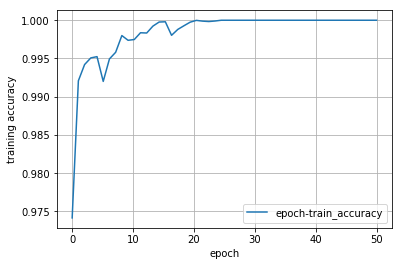

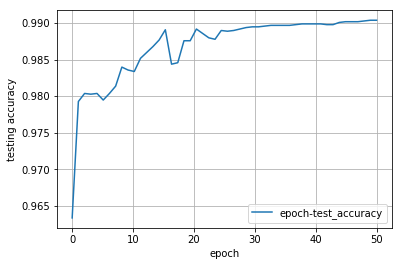

Highest test accuracy is: 0.990384615385
***** Last accuracy: 0.990


In [15]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = Super_Le_Net5()
    model.train(sess, X_train, Y_train, X_test, Y_test)
    accuracy = model.evaluate(sess, X_test, Y_test)
    print('***** Last accuracy: %.3f' % accuracy)
        
